# <center>Data Exploratory and Preparatory Notebook on the OWID COVID-19 Dataset</center>
<hr>

## <center>1. Reader's guide 📝</center>
<hr>
This section aims to elaborate on the data we will be handling as well as the end goal of the notebook.

### 1.1 Introduction
<br>
This notebook servers as an Exploratory Data Analysis (EDA) on the data provided by <a href="https://ourworldindata.org/">OWID</a> (Our World in Data). This data contains the information about the COVID-19 pandemic for every day for all the countries that recorded data. We will be primarily looking into <b>The Netherlands</b>.

### 1.2 Goal of the document
<br>
The primary question we are trying to answer is whether the current measures, together with the vaccination trends prove sufficient for dealing with the COVID-19 pandemic in The Netherlands. Our baseline for success will be the measures taken, combined with data about hospitalizations (severe to deadly cases), vaccination efforts, and recorded cases of infection.
<br>
<br>
The goal of this notebook is to explore and visualize trends in the data as well as what it provides. This notebook will also act as a preparation notebook for time-series modelling.

## <center>2. Introducing the data 🔎</center>
***  
This section aims to thoroughly research and reshape the data where needed.

### 2.1 Loading in & glancing over the data

Firstly, we will import the libraries required for the task of data wrangling and visualization.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from colorama import Fore

import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import datetime
from datetime import date

np.random.seed(21)

Next we load in and inspect the shape of the data.

In [2]:
df = pd.read_csv('./data/covid-data.csv')

In [3]:
df.shape

(84310, 59)

We have __84 310__ rows with __59__ columns.
***
Now we can look at what the data contains.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84310 entries, 0 to 84309
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               84310 non-null  object 
 1   continent                              80235 non-null  object 
 2   location                               84310 non-null  object 
 3   date                                   84310 non-null  object 
 4   total_cases                            82276 non-null  float64
 5   new_cases                              82274 non-null  float64
 6   new_cases_smoothed                     81273 non-null  float64
 7   total_deaths                           72644 non-null  float64
 8   new_deaths                             72802 non-null  float64
 9   new_deaths_smoothed                    81273 non-null  float64
 10  total_cases_per_million                81831 non-null  float64
 11  ne

In [5]:
df['date'].min()

'2020-01-01'

In [6]:
df['date'].max()

'2021-04-26'

Looks like the data contains a wide variety of criteria that can be inspected through the <a href="https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv">official documentation</a>. We can also see that the data ranges from __2020-01-01__ until __2021-04-26__. From the documentation it is also known that the data is updated daily.
***
Next we can look into duplicated or null values.

In [7]:
df.isnull().sum()

iso_code                                     0
continent                                 4075
location                                     0
date                                         0
total_cases                               2034
new_cases                                 2036
new_cases_smoothed                        3037
total_deaths                             11666
new_deaths                               11508
new_deaths_smoothed                       3037
total_cases_per_million                   2479
new_cases_per_million                     2481
new_cases_smoothed_per_million            3477
total_deaths_per_million                 12098
new_deaths_per_million                   11940
new_deaths_smoothed_per_million           3477
reproduction_rate                        16096
icu_patients                             75538
icu_patients_per_million                 75538
hosp_patients                            73724
hosp_patients_per_million                73724
weekly_icu_ad

In [8]:
df.duplicated().sum()

0

We can see that there are no duplicated values but there are some missing records from within the other columns. We will see which of them are relevant and we will find a way to fill them in.
***
Next we can look into the countries with the most and the countries with least amount of confirmed cases. We will limit that number to 10 for ease of visualization.

In [9]:
grouping_cc = df.groupby(['location', 'continent', 'date'])['total_cases'].sum()
grouping_r = grouping_cc.groupby(['location', 'continent']).max()
df_f = pd.DataFrame(grouping_r.groupby(['location']).sum().sort_values(ascending=False))
df_f = df_f.fillna('NA')

In [10]:
highest_10 = df_f.head(10)
lowest_10 = df_f.tail(10)

In [11]:
highest_10

,total_cases
location,
United States,32124869.0
India,17636186.0
Brazil,14369423.0
France,5565080.0
Russia,4717321.0
Turkey,4667281.0
United Kingdom,4422562.0
Italy,3971114.0
Spain,3488469.0


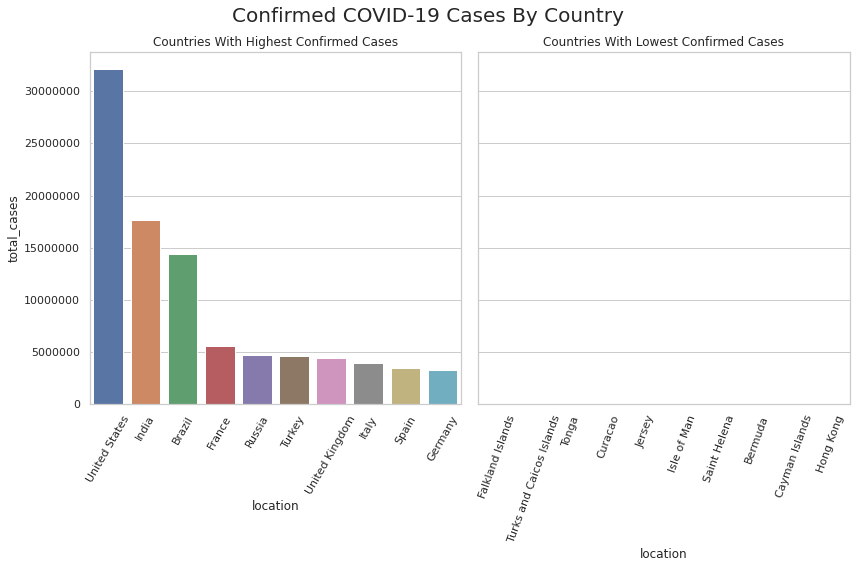

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True)
fig.suptitle('Confirmed COVID-19 Cases By Country', size=20)
sns.barplot(ax=ax[0],data=highest_10, x=highest_10.index, y='total_cases')
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].set_title('Countries With Highest Confirmed Cases')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=60)

sns.barplot(ax=ax[1],data=lowest_10, x=lowest_10.index, y='total_cases')
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title('Countries With Lowest Confirmed Cases')
ax[1].set_ylabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=70)

fig.tight_layout()

In the graph above, we have visualized the countries with most and the countries with least amount of confirmed cases. By a huge margin, US has the most confirmed cases, albeit the pandemic began in China that is not in this graph.
***
Now we will naively create a new `DataFrame` object that contains only the features we are currently interested in. Those are the confirmed cases, vaccination efforts, hospitalizations, deaths, testing, and most importantly, strictness of the lockdown. We will be working with data for _The Netherlands_.

In [13]:
df_n = df[['date', 'location', 'total_cases', 'people_vaccinated', 'people_fully_vaccinated', 'hosp_patients','total_deaths' , 'total_tests', 'stringency_index']].copy()
df_n = df_n[df_n['location'] == 'Netherlands']
df_n.head(10)

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
53399,2020-02-27,Netherlands,1.0,NaN,NaN,1.0,NaN,NaN,5.56
53400,2020-02-28,Netherlands,1.0,NaN,NaN,9.0,NaN,NaN,5.56
53401,2020-02-29,Netherlands,6.0,NaN,NaN,10.0,NaN,NaN,5.56
53402,2020-03-01,Netherlands,10.0,NaN,NaN,20.0,NaN,NaN,5.56
53403,2020-03-02,Netherlands,18.0,NaN,NaN,34.0,NaN,NaN,5.56
53404,2020-03-03,Netherlands,24.0,NaN,NaN,40.0,NaN,NaN,5.56
53405,2020-03-04,Netherlands,38.0,NaN,NaN,53.0,NaN,NaN,5.56
53406,2020-03-05,Netherlands,82.0,NaN,NaN,65.0,NaN,NaN,5.56
53407,2020-03-06,Netherlands,128.0,NaN,NaN,77.0,1.0,NaN,11.11
53408,2020-03-07,Netherlands,188.0,NaN,NaN,93.0,1.0,NaN,11.11


We will also parse the `date` column since this is a time-series problem.

In [14]:
df_n['date'] = pd.to_datetime(df_n['date'])

In [15]:
# Remove old rows
df_n = df_n[df_n['total_deaths'].notna() & df_n['total_cases'].notna()].reset_index(drop=True)
df_n.head(10)

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
0,2020-03-06,Netherlands,128.0,NaN,NaN,77.0,1.0,NaN,11.11
1,2020-03-07,Netherlands,188.0,NaN,NaN,93.0,1.0,NaN,11.11
2,2020-03-08,Netherlands,265.0,NaN,NaN,108.0,3.0,NaN,11.11
3,2020-03-09,Netherlands,321.0,NaN,NaN,141.0,3.0,NaN,11.11
4,2020-03-10,Netherlands,382.0,NaN,NaN,174.0,4.0,NaN,20.83
5,2020-03-11,Netherlands,503.0,NaN,NaN,215.0,5.0,NaN,20.83
6,2020-03-12,Netherlands,503.0,NaN,NaN,283.0,5.0,NaN,45.37
7,2020-03-13,Netherlands,806.0,NaN,NaN,350.0,10.0,NaN,53.70
8,2020-03-14,Netherlands,962.0,NaN,NaN,424.0,12.0,NaN,53.70
9,2020-03-15,Netherlands,1138.0,NaN,NaN,500.0,20.0,17080.0,53.70


In [16]:
# Remove continents and extra from location
# df_n = df_n[~df_n['location'].isin(['Africa', 'North America', 'Europe', 'World', 'Asia', 'Antarctica', 'South America', 'Oceania'])]

# Assign targets
targets = ['total_cases', 'stringency_index']

# Assign features
features = [f for f in df_n.columns if f not in targets]

df_n.head(10)

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
0,2020-03-06,Netherlands,128.0,NaN,NaN,77.0,1.0,NaN,11.11
1,2020-03-07,Netherlands,188.0,NaN,NaN,93.0,1.0,NaN,11.11
2,2020-03-08,Netherlands,265.0,NaN,NaN,108.0,3.0,NaN,11.11
3,2020-03-09,Netherlands,321.0,NaN,NaN,141.0,3.0,NaN,11.11
4,2020-03-10,Netherlands,382.0,NaN,NaN,174.0,4.0,NaN,20.83
5,2020-03-11,Netherlands,503.0,NaN,NaN,215.0,5.0,NaN,20.83
6,2020-03-12,Netherlands,503.0,NaN,NaN,283.0,5.0,NaN,45.37
7,2020-03-13,Netherlands,806.0,NaN,NaN,350.0,10.0,NaN,53.70
8,2020-03-14,Netherlands,962.0,NaN,NaN,424.0,12.0,NaN,53.70
9,2020-03-15,Netherlands,1138.0,NaN,NaN,500.0,20.0,17080.0,53.70


## <center>3. Data visualization 📈</center>
<hr>

Features:
<br>
* `people_vaccinated` indicates the number of people who received at least first vaccination dose
* `people_fully_vaccinated` indicates the number of people who received the full vaccination dose 
* `hosp_patients` indicates the number of hospitalized people in a given day
* `total_deaths` indicates the number of deaths due to COVID-19
* `total_tests` indicates the number of tests for COVID-19

Targets:
<br>
* `total_cases` indicates the number of confirmed cases
* `stringency_index` indicates the government response. This index is a composite measure based on the 9 response indicators including school closure, workplace closure, travel bans, etc. The value is rescaled from 0 to 100 with 0 being the lightest and 100 being the strictest measures.

In [17]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     417 non-null    datetime64[ns]
 1   location                 417 non-null    object        
 2   total_cases              417 non-null    float64       
 3   people_vaccinated        14 non-null     float64       
 4   people_fully_vaccinated  12 non-null     float64       
 5   hosp_patients            408 non-null    float64       
 6   total_deaths             417 non-null    float64       
 7   total_tests              58 non-null     float64       
 8   stringency_index         413 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 29.4+ KB


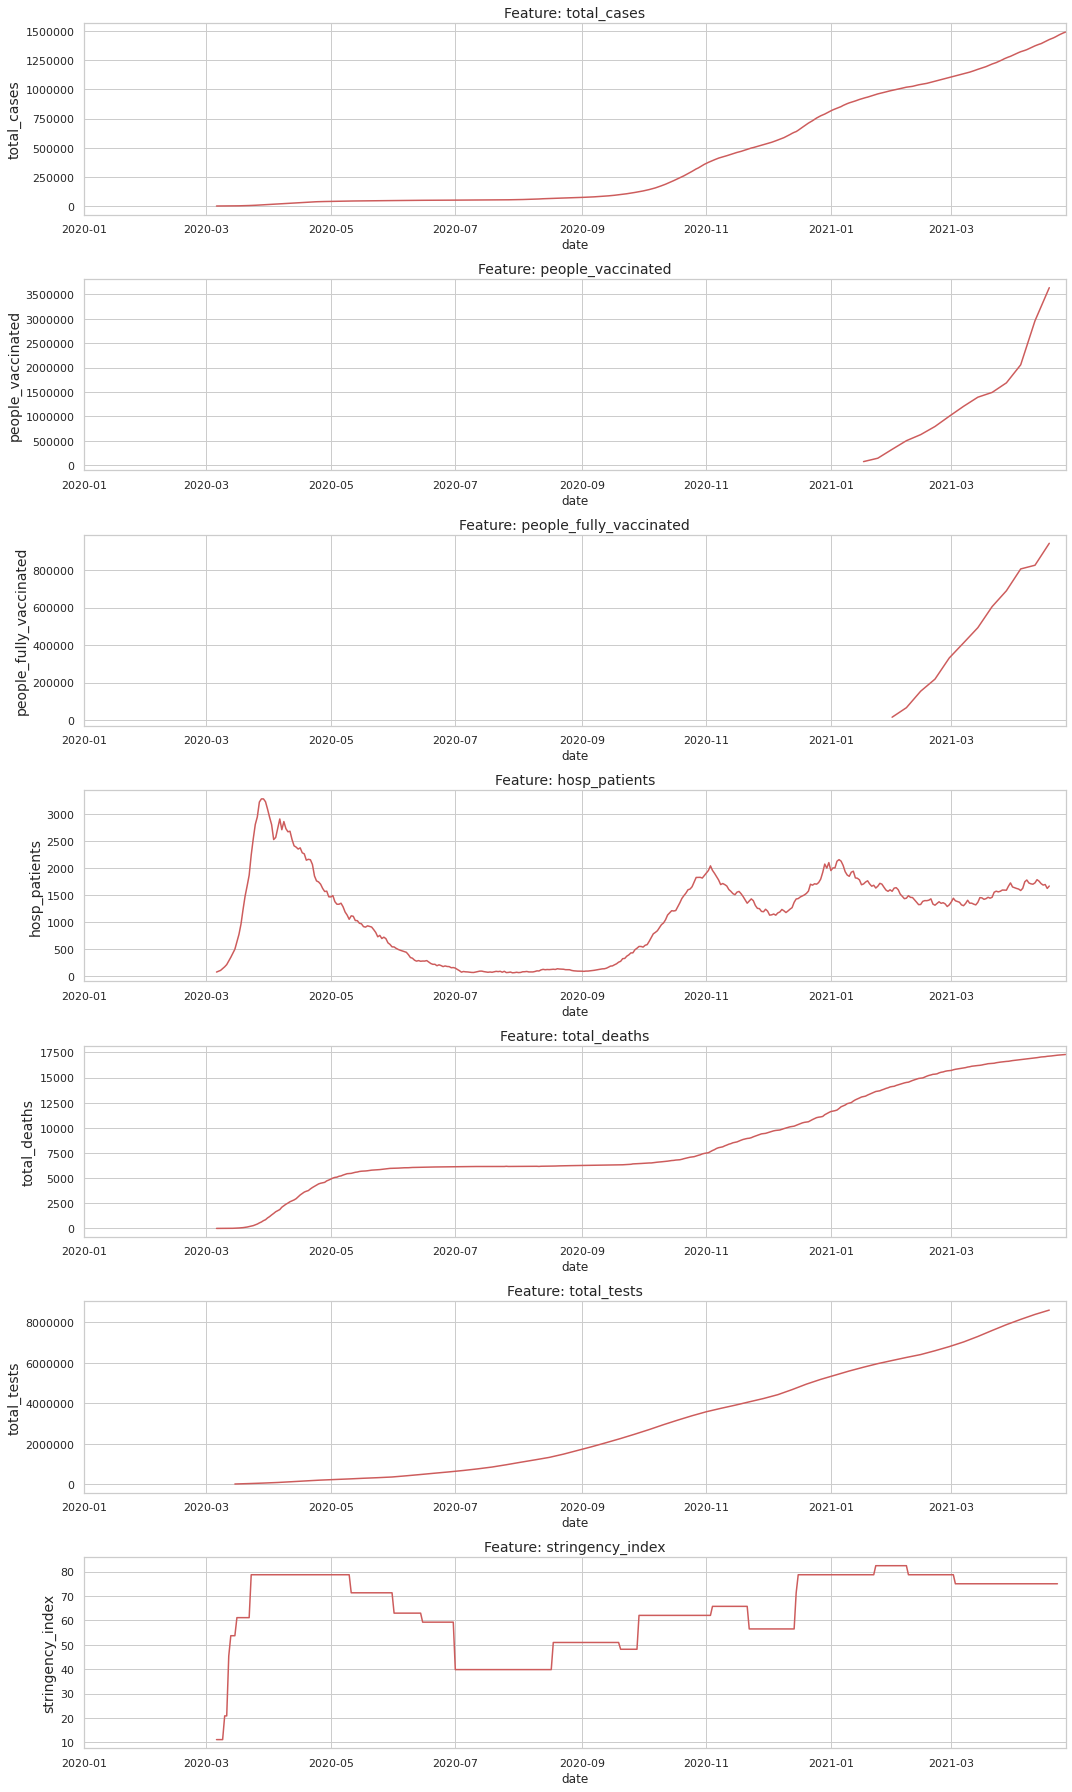

In [18]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df_n.drop(['date', 'location'], axis=1).columns):
    sns.lineplot(x=df_n['date'], y=df_n[column], ax=ax[i], color='indianred')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].ticklabel_format(style='plain', axis='y')
    
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])

fig.tight_layout()

## <center>4. Data Preprocessing 🔨</center>
<hr>

### Checking Chronological Order and Ensuring Equidistant Timestamps

Since we are going to work with time series, we also need to make sure that the data is in chronological order and the timestamps are equidistant. The former will be checked by sorting the `DataFrame` object on the `date` column. The latter indicates constant time intervals which are an integral when it comes to predicting time-series. To check this, we will look at the difference between each timestamp and when it was taken.

In [19]:
df_n = df_n.sort_values(by='date')
df_n.head()

,date,location,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index
0,2020-03-06,Netherlands,128.0,NaN,NaN,77.0,1.0,NaN,11.11
1,2020-03-07,Netherlands,188.0,NaN,NaN,93.0,1.0,NaN,11.11
2,2020-03-08,Netherlands,265.0,NaN,NaN,108.0,3.0,NaN,11.11
3,2020-03-09,Netherlands,321.0,NaN,NaN,141.0,3.0,NaN,11.11
4,2020-03-10,Netherlands,382.0,NaN,NaN,174.0,4.0,NaN,20.83


In [20]:
df_n['delta'] = df_n['date'] - df_n['date'].shift(1)
df_n[['date', 'delta']].head()

,date,delta
0,2020-03-06,NaT
1,2020-03-07,1 days
2,2020-03-08,1 days
3,2020-03-09,1 days
4,2020-03-10,1 days


In [21]:
df_n['delta'].sum(), df_n['delta'].count()

(Timedelta('416 days 00:00:00'), 416)

The data is already structurally sound and formatted. The timestamp interval is one day and the data is in chronological order.
***

### <center> 4.1 Handling Missing Values 💔</center>

Firstly, we should look into the `DataFrame` object and inspect where do we have missing values. We will replace them with `NaN` and fill them later on.

In [22]:
df_n = df_n.drop('delta', axis=1)
df_n.isna().sum()

date                         0
location                     0
total_cases                  0
people_vaccinated          403
people_fully_vaccinated    405
hosp_patients                9
total_deaths                 0
total_tests                359
stringency_index             4
dtype: int64

Next we should look into the amount of missing values and decide how should we fill them in.

In [23]:
df_n['stringency_index'] = df_n['stringency_index'].replace(0, np.nan)
df_n['people_vaccinated'] = df_n['people_vaccinated'].replace(0, np.nan)
df_n['people_fully_vaccinated'] = df_n['people_fully_vaccinated'].replace(0, np.nan)
df_n['hosp_patients'] = df_n['hosp_patients'].replace(0, np.nan)
df_n['total_tests'] = df_n['total_tests'].replace(0, np.nan)

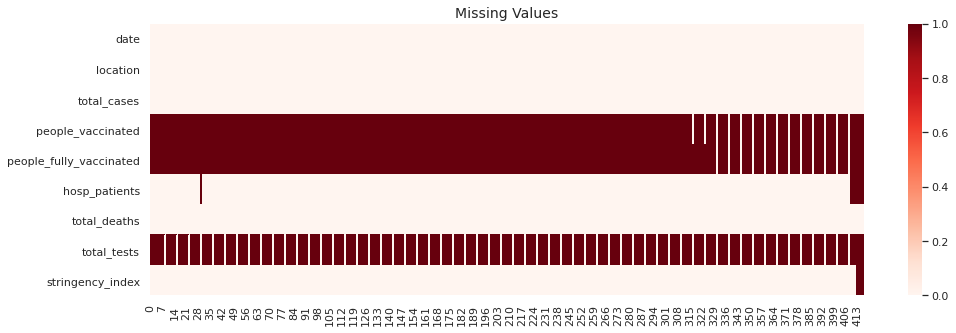

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

sns.heatmap(df_n.T.isna(), cmap='Reds')
ax.set_title('Missing Values', fontsize=14)

plt.show()

We have a lot of missing values to deal with and we are going to explore 4 options:
* Option 1: Fill NaN with Outlier or Zero
* Option 2: Fill NaN with Mean Value
* Option 3: Fill NaN with Last Value with `.ffill()`
* Option 4: Fill NaN with Linearly Interpolated Value with `.interpolate()`

We will be exploring these options for only one feature and apply the same for the others due to the character of the missing values.

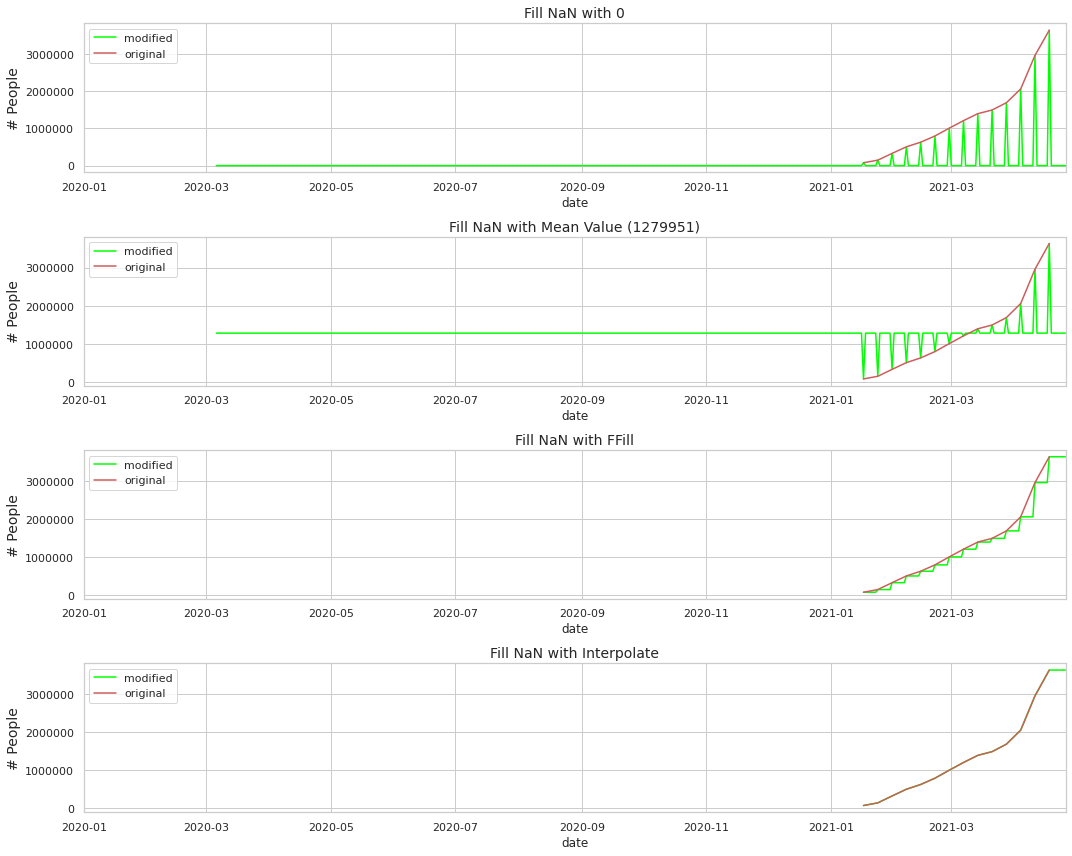

In [25]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].fillna(0), ax=ax[0], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[0], color='indianred', label = 'original')
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='# People', fontsize=14)

mean_pv = df_n['people_vaccinated'].mean()
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].fillna(mean_pv), ax=ax[1], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[1], color='indianred', label = 'original')
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_pv:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='# People', fontsize=14)

sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].ffill(), ax=ax[2], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[2], color='indianred', label = 'original')
ax[2].ticklabel_format(style='plain', axis='y')
ax[2].set_title('Fill NaN with FFill', fontsize=14)
ax[2].set_ylabel(ylabel='# People', fontsize=14)

sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].interpolate(), ax=ax[3], color='lime', label = 'modified')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[3], color='indianred', label = 'original')
ax[3].ticklabel_format(style='plain', axis='y')
ax[3].set_title('Fill NaN with Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='# People', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])

fig.tight_layout()

We can also look how our missing values will look now after interpolating.

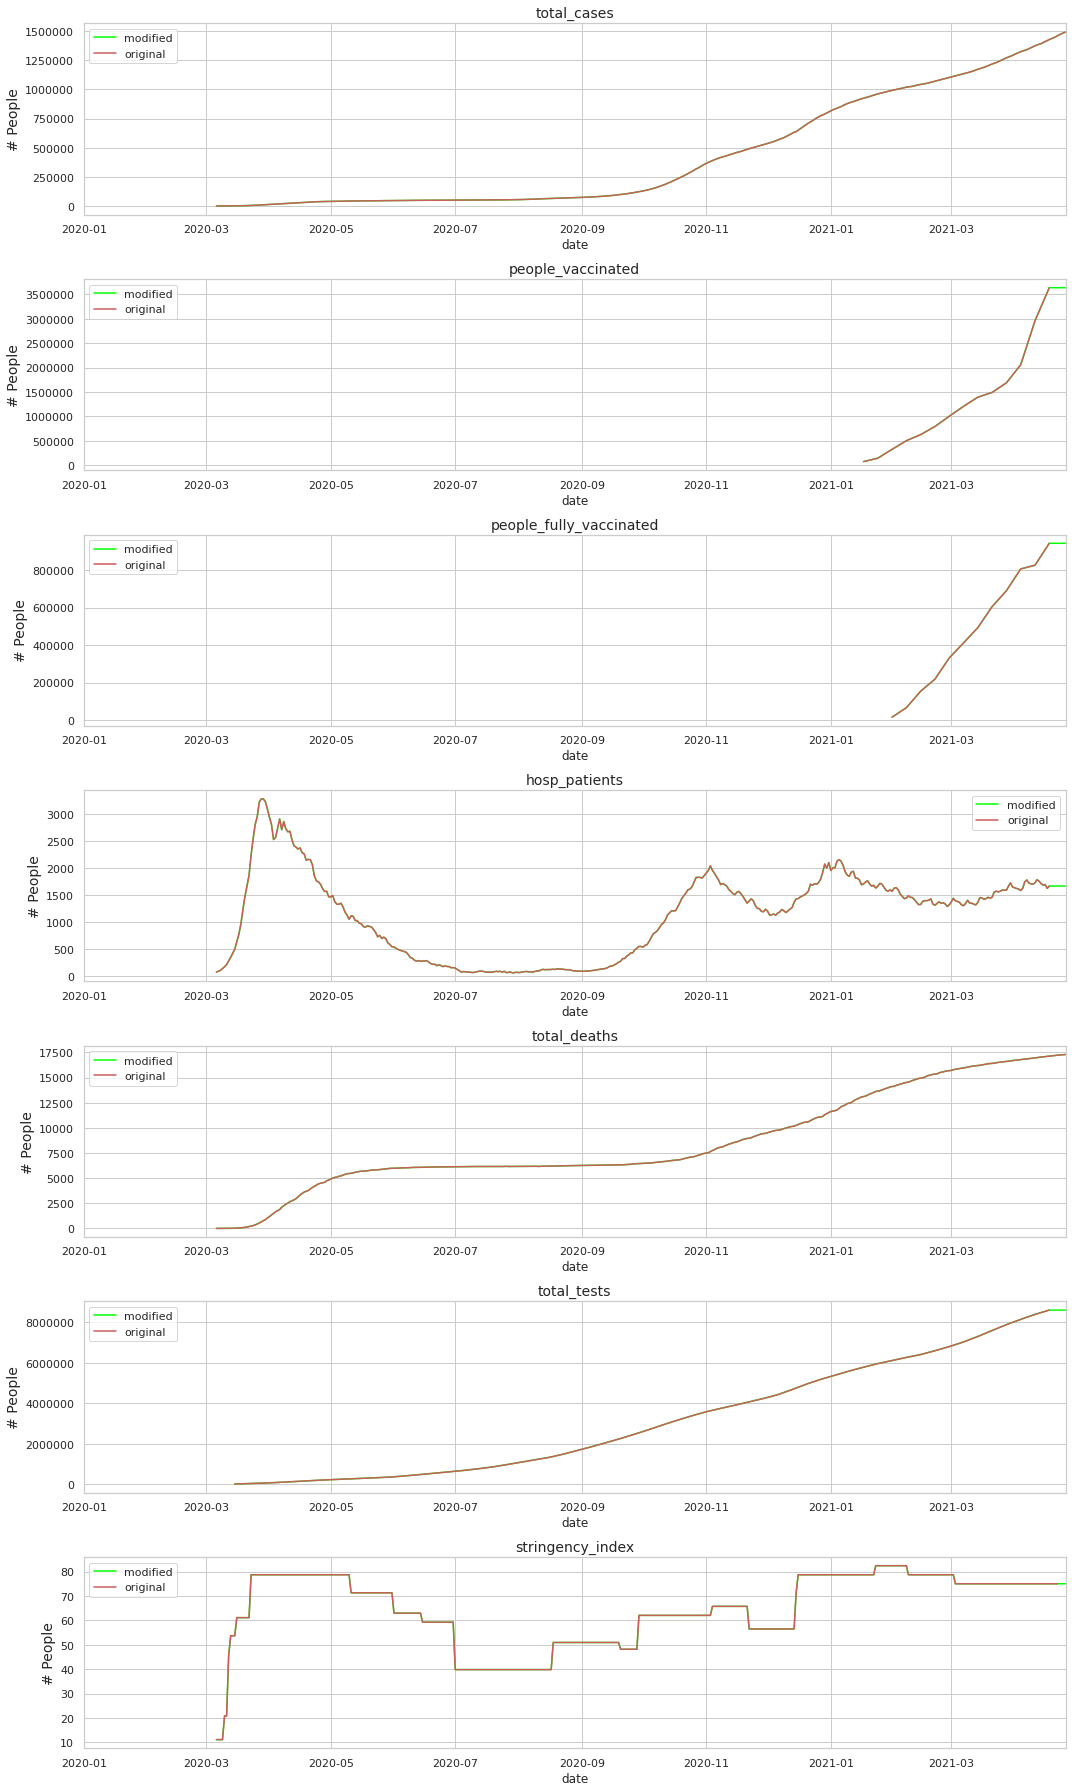

In [26]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df_n.drop(['date', 'location'], axis=1).columns):
    sns.lineplot(x=df_n['date'], y=df_n[column].interpolate(), ax=ax[i], color='lime', label = 'modified')
    sns.lineplot(x=df_n['date'], y=df_n[column], ax=ax[i], color='indianred', label = 'original')
    ax[i].ticklabel_format(style='plain', axis='y')
    ax[i].set_title('{}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel='# People', fontsize=14)
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    df_n[column].interpolate(inplace=True)
    
fig.tight_layout()

We will be using the `interpolate()` version of the filling since we want to patch the missing future values.  
Now we need to patch the past `NaN` values and since they are non-recorded cases, filling them with 0 might be the best option.

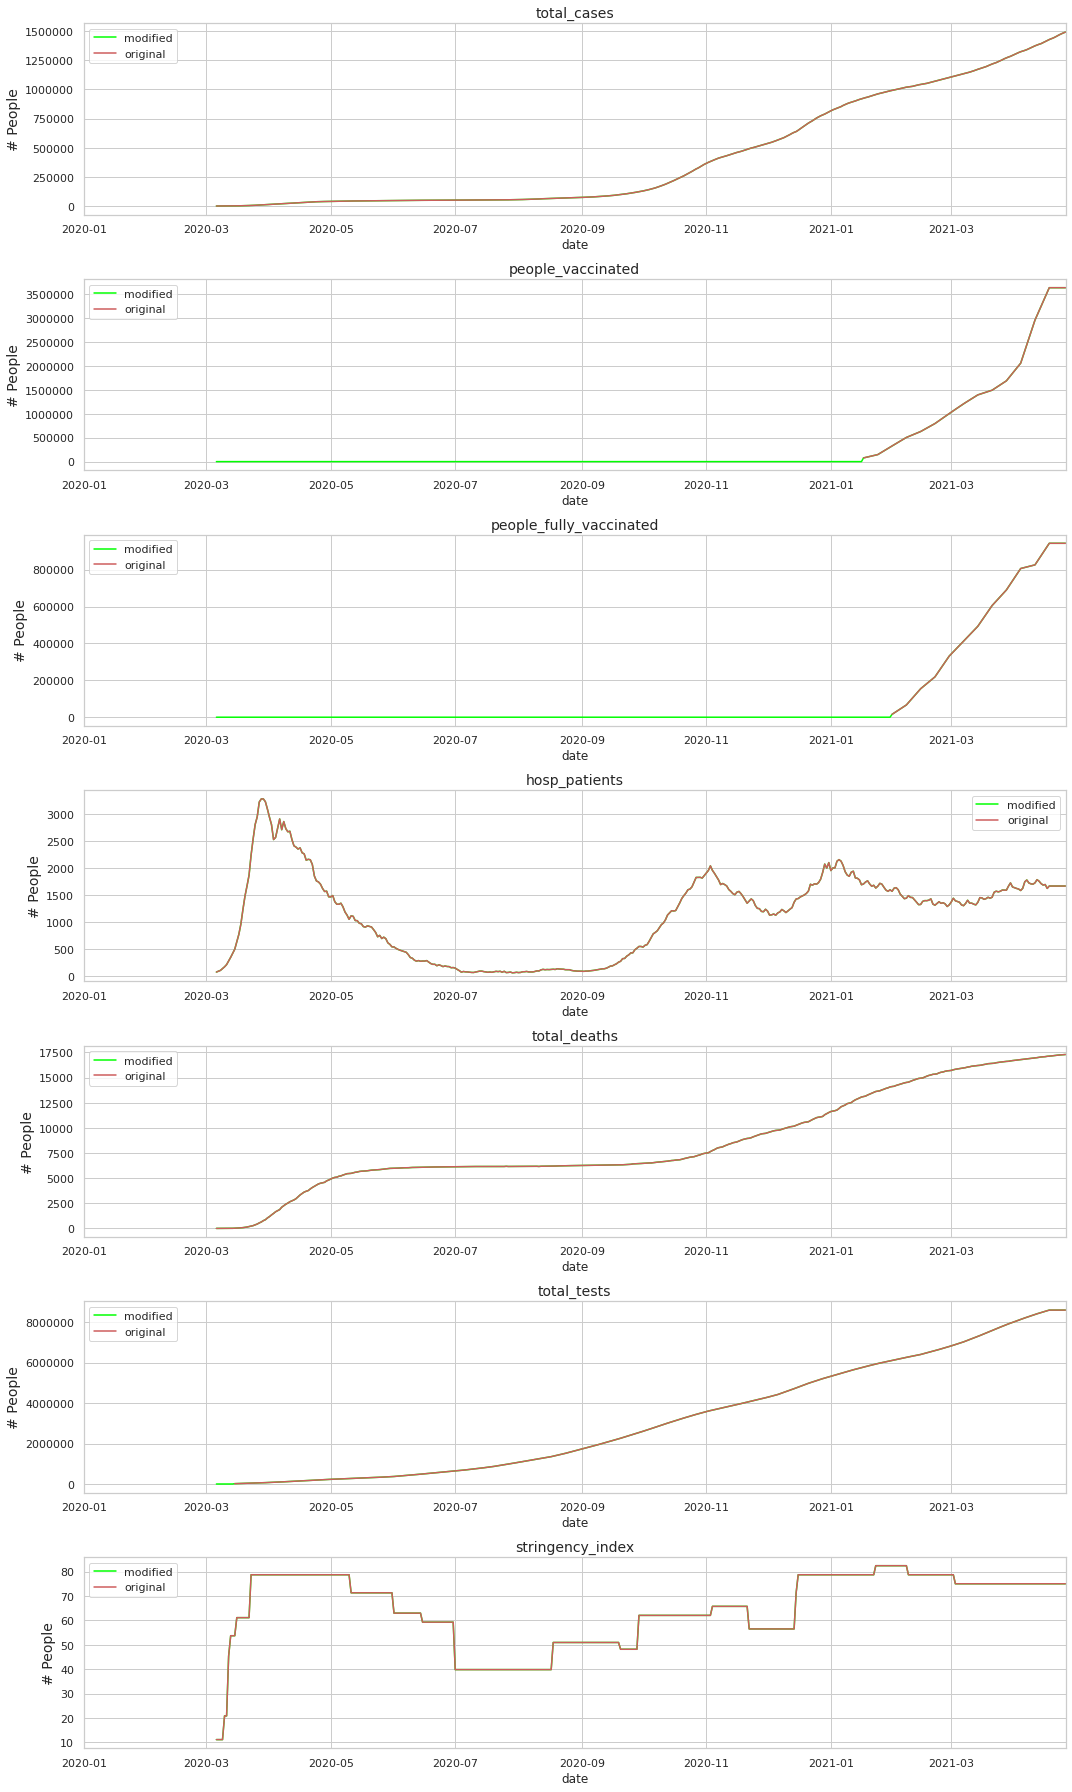

In [27]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df_n.drop(['date', 'location'], axis=1).columns):
    sns.lineplot(x=df_n['date'], y=df_n[column].fillna(0), ax=ax[i], color='lime', label = 'modified')
    sns.lineplot(x=df_n['date'], y=df_n[column], ax=ax[i], color='indianred', label = 'original')
    ax[i].ticklabel_format(style='plain', axis='y')
    ax[i].set_title('{}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel='# People', fontsize=14)
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    df_n[column].fillna(0, inplace=True)
    
fig.tight_layout()

This would help us later when modelling with _ARIMA_ and rejecting the null hypothesis.

### <center>4.2 Smoothing data 🌊</center>

Next, we should try observing whether the data is too frequent or infrequent. As we have daily records it would benefit us the most to look at the bigger picture. This will be done by resampling the data. In order to achieve that we will be __downsampling__ it.

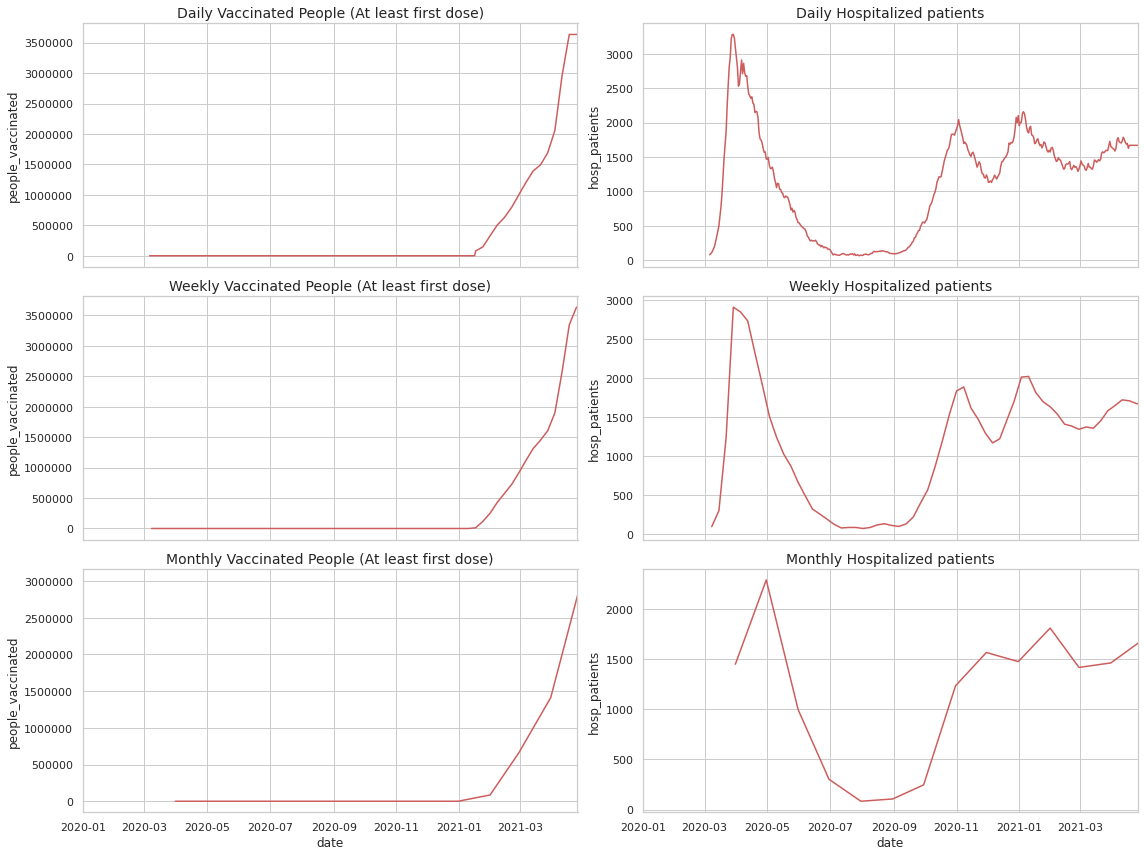

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16, 12))

# baseline data
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], color='indianred', ax=ax[0, 0])
ax[0, 0].set_title('Daily Vaccinated People (At least first dose)', fontsize=14)
ax[0, 0].ticklabel_format(style='plain', axis='y')

# weekly is denoted by W
resampled_df_n = df_n[['date', 'people_vaccinated']].resample('W', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_n['date'], y=resampled_df_n['people_vaccinated'], color='indianred', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Vaccinated People (At least first dose)', fontsize=14)
ax[1, 0].ticklabel_format(style='plain', axis='y')

# monthly is denoted by M
resampled_df_n = df_n[['date', 'people_vaccinated']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_n['date'], y=resampled_df_n['people_vaccinated'], color='indianred', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Vaccinated People (At least first dose)', fontsize=14)
ax[2, 0].ticklabel_format(style='plain', axis='y')

for i in range(3):
    ax[i, 0].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    
# baseline data
sns.lineplot(x=df_n['date'], y=df_n['hosp_patients'], color='indianred', ax=ax[0, 1])
ax[0, 1].set_title('Daily Hospitalized patients', fontsize=14)

# weekly is denoted by W
resampled_df_n = df_n[['date', 'hosp_patients']].resample('W', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_n['date'], y=resampled_df_n['hosp_patients'], color='indianred', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Hospitalized patients', fontsize=14)

# monthly is denoted by M
resampled_df_n = df_n[['date', 'hosp_patients']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df_n['date'], y=resampled_df_n['hosp_patients'], color='indianred', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Hospitalized patients', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    
fig.tight_layout()

We can observe a better overview of the trends on the weekly graph. Downsampling the data to weekly could potentially smoothen the data out and help with analysis. In order to not disrupt the current trends we will be taking the mean values.

In [29]:
downsample = df_n[['date', 
                   'total_cases', 
                   'people_vaccinated', 
                   'people_fully_vaccinated', 
                   'hosp_patients', 
                   'total_deaths', 
                   'total_tests', 
                   'stringency_index']].resample('W', on='date').mean().reset_index(drop=False)
df_n = downsample.copy()

### <center>4.3 Checking Stationarity</center>

We will working with time-series models, such as _ARIMA_. These models often rely that the data supplied is stationary. So we will be looking for constant _mean_, _variance_, and _covariance_ as well as the fact that these three factors are independent of time.
<br>
<br>
To achieve our goal we will research the following:
<ul>
    <li>plot the data and check for trends or seasonality.</li> 
    <li>split the data and compare the <i>mean</i> and <i>variance</i> of each partition. </li>
    <li>a statistical test in the form of an <b>ADF</b> (Augmented Dickey Fuller). This test is used to check for seasonality.</li>
</ul>

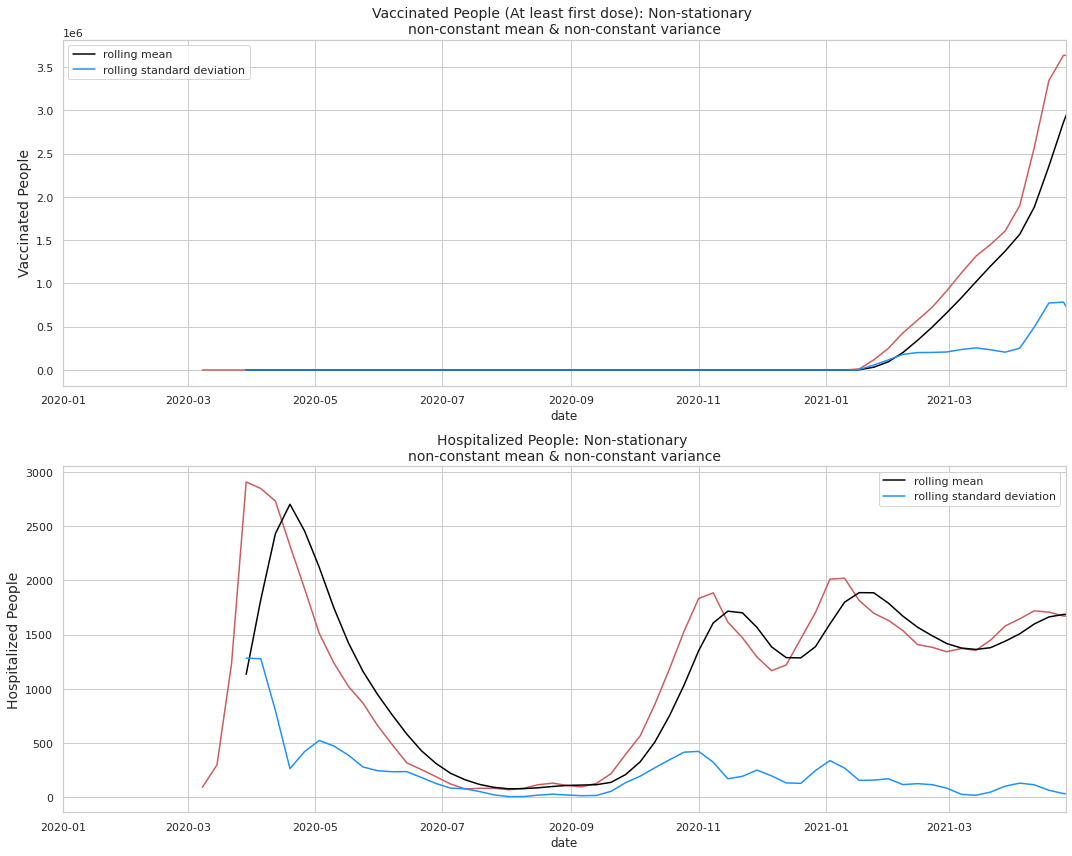

In [30]:
# 4 weeks roughly in a month, so 4 observations per partition
rolling_window = 4

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'], ax=ax[0], color='indianred')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df_n['date'], y=df_n['people_vaccinated'].rolling(rolling_window).std(), ax=ax[0], color='dodgerblue', label='rolling standard deviation')
ax[0].set_title('Vaccinated People (At least first dose): Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Vaccinated People', fontsize=14)
ax[0].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])

sns.lineplot(x=df_n['date'], y=df_n['hosp_patients'], ax=ax[1], color='indianred')
sns.lineplot(x=df_n['date'], y=df_n['hosp_patients'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df_n['date'], y=df_n['hosp_patients'].rolling(rolling_window).std(), ax=ax[1], color='dodgerblue', label='rolling standard deviation')
ax[1].set_title('Hospitalized People: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1].set_ylabel(ylabel='Hospitalized People', fontsize=14)
ax[1].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])

fig.tight_layout()

#### Augmented Dickey-Fuller (ADF)  
We want a time-series that has no unit root which means that the time-series is stationary. We are looking for a _p_ < _0.05(default)_. The null hypothesis could also be rejected with an _ADF statistic_ < _critical value_. (all critical values are 1%, 5%, 10%)

In [31]:
result = adfuller(df_n['people_vaccinated'])
result

(-3.8690405748264807,
 0.0022748816640263845,
 11,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 1170.7581139430192)

Now, we are going to check for each variable:  
* _p_ < 0.05  
* Check the range of the ADF statistic compared with _critical\_values_. _stats_ < _critical\_values_ (1%, 5%, 10%)

In [32]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']
    
    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df_n['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)
    ax.ticklabel_format(style='plain', axis='y')

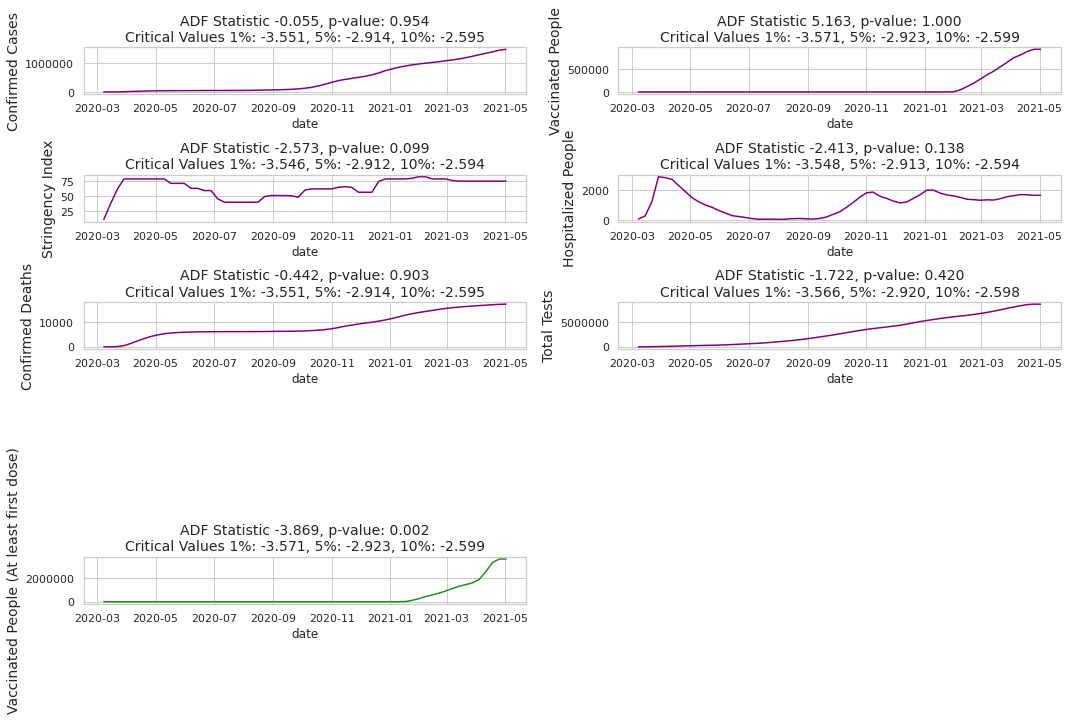

In [33]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 9))

visualize_adfuller_results(df_n['total_cases'].values, 'Confirmed Cases', ax[0, 0])
visualize_adfuller_results(df_n['people_vaccinated'].values, 'Vaccinated People (At least first dose)', ax[4, 0])
visualize_adfuller_results(df_n['people_fully_vaccinated'].values, 'Vaccinated People', ax[0, 1])
visualize_adfuller_results(df_n['hosp_patients'].values, 'Hospitalized People', ax[1, 1])
visualize_adfuller_results(df_n['total_deaths'].values, 'Confirmed Deaths', ax[2, 0])
visualize_adfuller_results(df_n['total_tests'].values, 'Total Tests', ax[2, 1])
visualize_adfuller_results(df_n['stringency_index'].values, 'Stringency Index', ax[1, 0])

fig.delaxes(ax[3, 0])
fig.delaxes(ax[3, 1])
fig.delaxes(ax[4, 1])
fig.tight_layout()

Since only one feature rejects the null hypothesis (`people_vaccinated`), we need to transform the other from non-stationary to stationary time-series. This will be achieved by _differencing_ them as many times as needed and plotting them out again.

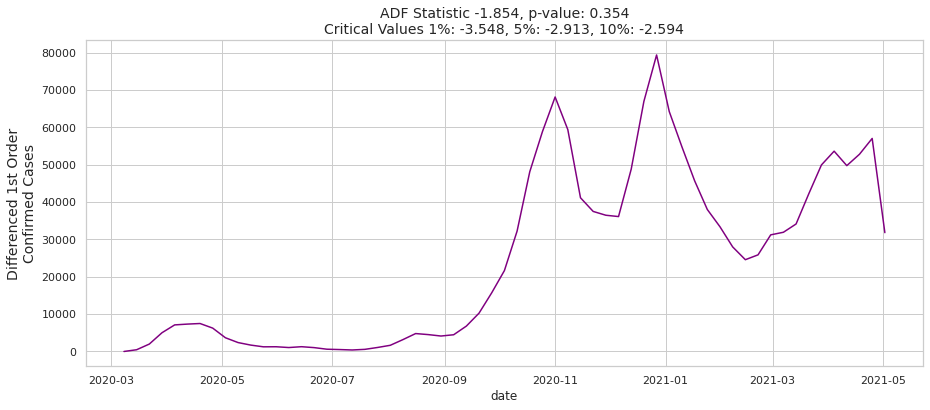

In [34]:
diff = np.diff(df_n['total_cases'])
df_n['total_cases_diff_1'] = np.append([0], diff)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['total_cases_diff_1'], 'Differenced 1st Order\nConfirmed Cases', ax)

First order differencing did not solve our issue, so we need to try second-order differencing. In simple terms - difference the differenced values.

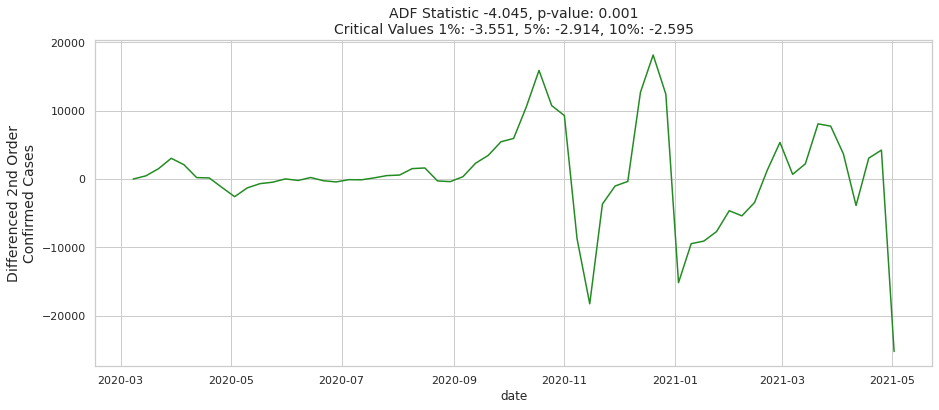

In [35]:
diff_2 = np.diff(df_n['total_cases_diff_1'])
df_n['total_cases_diff_2'] = np.append([0], diff_2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['total_cases_diff_2'], 'Differenced 2nd Order\nConfirmed Cases', ax)

As we can see, second-order differencing gave us the right result. The transformations rejected the null hypothesis, meaning our data is now stationary.  
We need to do the same for the other features as well.

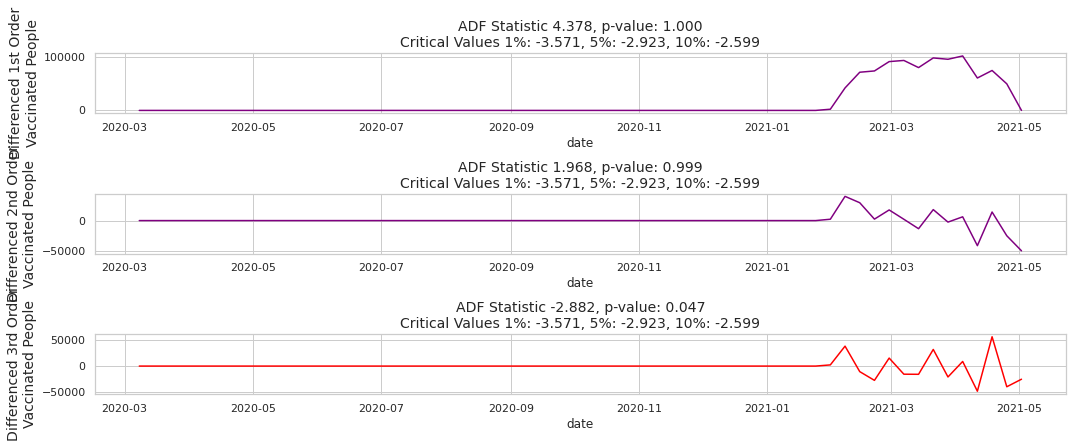

In [36]:
diff = np.diff(df_n['people_fully_vaccinated'])
df_n['people_fully_vaccinated_diff_1'] = np.append([0], diff)

diff2 = np.diff(df_n['people_fully_vaccinated_diff_1'])
df_n['people_fully_vaccinated_diff_2'] = np.append([0], diff2)

diff3 = np.diff(df_n['people_fully_vaccinated_diff_2'])
df_n['people_fully_vaccinated_diff_3'] = np.append([0], diff3)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['people_fully_vaccinated_diff_1'], 'Differenced 1st Order\nVaccinated People', ax[0])
visualize_adfuller_results(df_n['people_fully_vaccinated_diff_2'], 'Differenced 2nd Order\nVaccinated People', ax[1])
visualize_adfuller_results(df_n['people_fully_vaccinated_diff_3'], 'Differenced 3rd Order\nVaccinated People', ax[2])

fig.tight_layout()

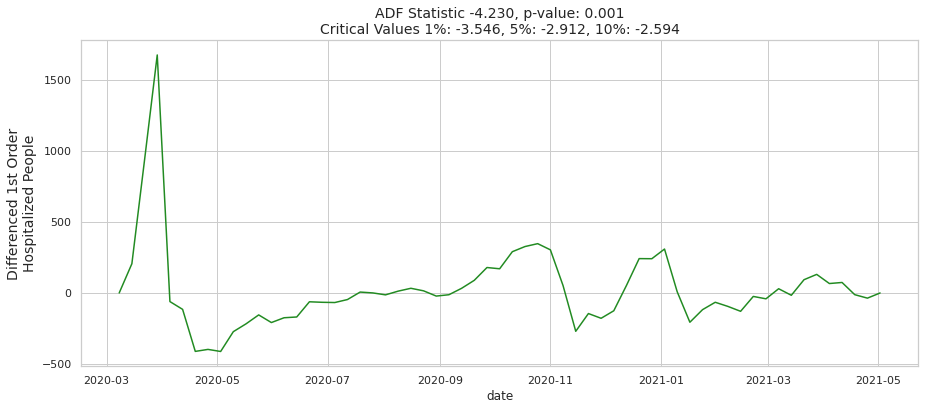

In [37]:
diff = np.diff(df_n['hosp_patients'])
df_n['hosp_patients_diff_1'] = np.append([0], diff)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['hosp_patients_diff_1'], 'Differenced 1st Order\nHospitalized People', ax)

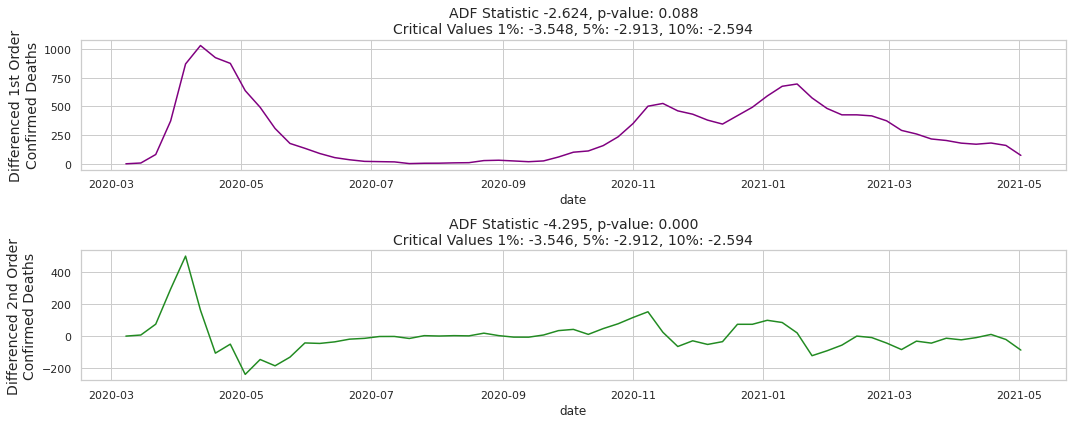

In [38]:
diff = np.diff(df_n['total_deaths'])
df_n['total_deaths_diff_1'] = np.append([0], diff)
diff2 = np.diff(df_n['total_deaths_diff_1'])
df_n['total_deaths_diff_2'] = np.append([0], diff2)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['total_deaths_diff_1'], 'Differenced 1st Order\nConfirmed Deaths', ax[0])
visualize_adfuller_results(df_n['total_deaths_diff_2'], 'Differenced 2nd Order\nConfirmed Deaths', ax[1])

fig.tight_layout()

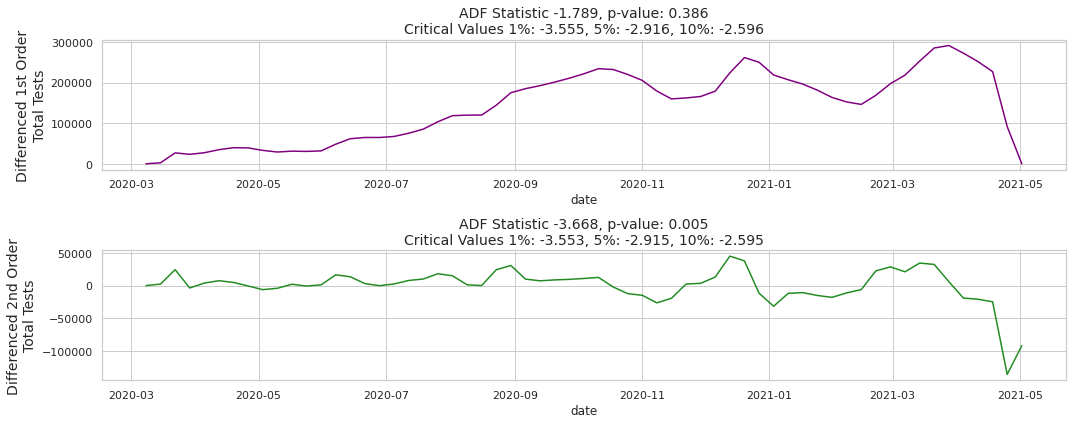

In [39]:
diff = np.diff(df_n['total_tests'])
df_n['total_tests_diff_1'] = np.append([0], diff)
diff2 = np.diff(df_n['total_tests_diff_1'])
df_n['total_tests_diff_2'] = np.append([0], diff2)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['total_tests_diff_1'], 'Differenced 1st Order\nTotal Tests', ax[0])
visualize_adfuller_results(df_n['total_tests_diff_2'], 'Differenced 2nd Order\nTotal Tests', ax[1])

fig.tight_layout()

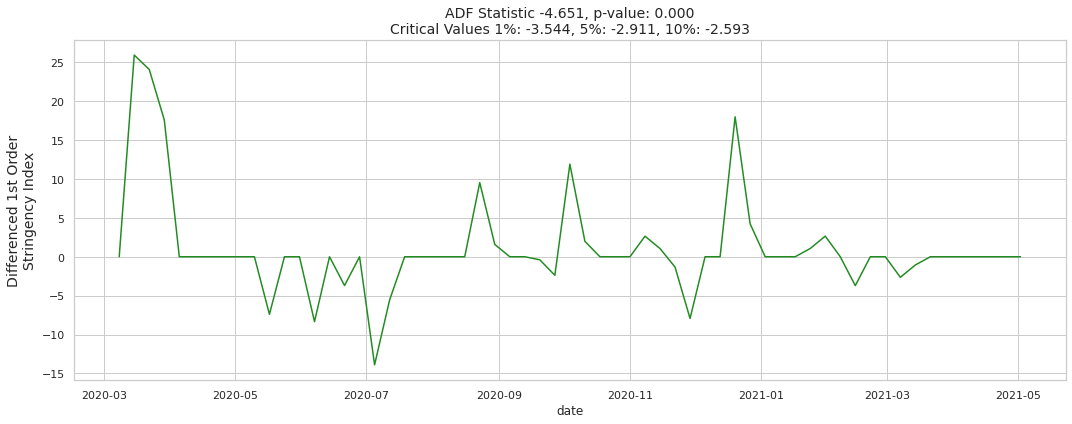

In [40]:
diff = np.diff(df_n['stringency_index'])
df_n['stringency_index_diff_1'] = np.append([0], diff)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_n['stringency_index_diff_1'], 'Differenced 1st Order\nStringency Index', ax)

fig.tight_layout()

In [41]:
df_n['total_cases_diff'] = df_n['total_cases_diff_2']
df_n['people_fully_vaccinated_diff'] = df_n['people_fully_vaccinated_diff_3']
df_n['hosp_patients_diff'] = df_n['hosp_patients_diff_1']
df_n['total_deaths_diff'] = df_n['total_deaths_diff_2']
df_n['total_tests_diff'] = df_n['total_tests_diff_2']
df_n['stringency_index_diff'] = df_n['stringency_index_diff_1']

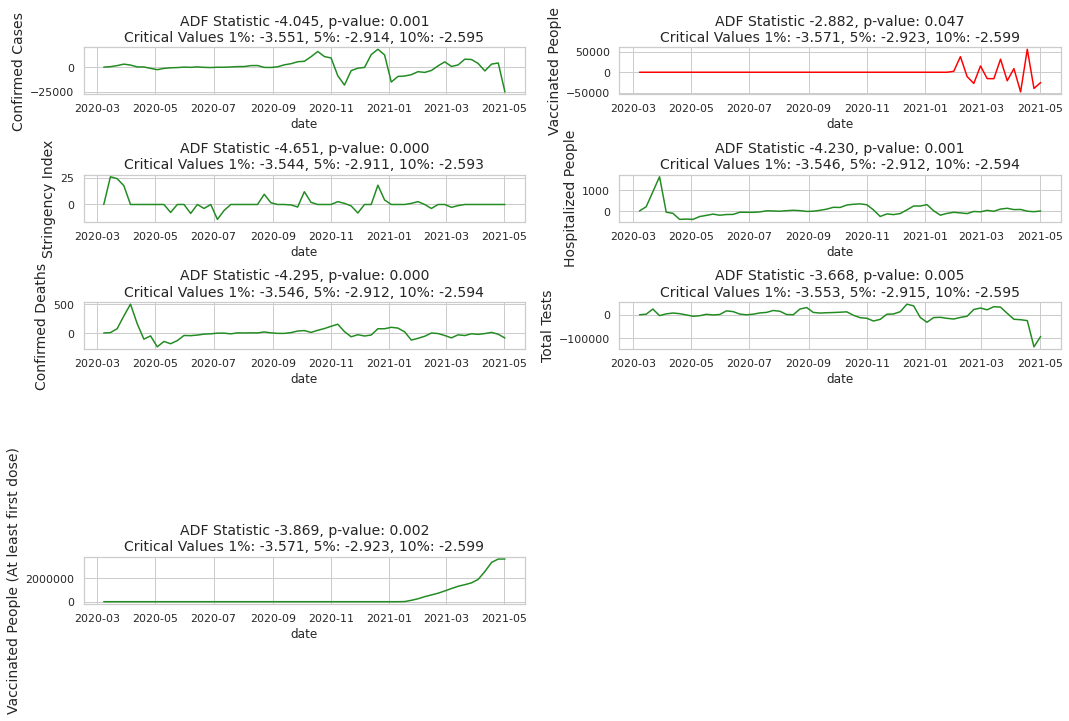

In [42]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 9))

visualize_adfuller_results(df_n['total_cases_diff'].values, 'Confirmed Cases', ax[0, 0])
visualize_adfuller_results(df_n['people_vaccinated'].values, 'Vaccinated People (At least first dose)', ax[4, 0])
visualize_adfuller_results(df_n['people_fully_vaccinated_diff'].values, 'Vaccinated People', ax[0, 1])
visualize_adfuller_results(df_n['hosp_patients_diff'].values, 'Hospitalized People', ax[1, 1])
visualize_adfuller_results(df_n['total_deaths_diff'].values, 'Confirmed Deaths', ax[2, 0])
visualize_adfuller_results(df_n['total_tests_diff'].values, 'Total Tests', ax[2, 1])
visualize_adfuller_results(df_n['stringency_index_diff'].values, 'Stringency Index', ax[1, 0])

fig.delaxes(ax[3, 0])
fig.delaxes(ax[3, 1])
fig.delaxes(ax[4, 1])
fig.tight_layout()

Let us drop the temporary columns left from differencing.

In [43]:
df_n = df_n.drop(['total_cases_diff_1', 'total_cases_diff_2', 
                  'people_fully_vaccinated_diff_1', 'people_fully_vaccinated_diff_2', 'people_fully_vaccinated_diff_3', 
                  'hosp_patients_diff_1', 'total_deaths_diff_1', 'total_deaths_diff_2',
                  'total_tests_diff_1', 'total_tests_diff_2', 'stringency_index_diff_1'], axis=1)

Now this is satisfactory for later modelling. We have rejected the null hypothesis on all our features. We have also created another copied `DataFrame` that contains the differenced columns.
***

## <center>5. Feature Engineering 🔧</center>

Now we need to get a generally better understanding of our data for forecasting. This is why why will be using __time-series decomposition__. This way we will think about the series as a combination of level, trend, seasonality, and noise. It is useful to __decompose__ the data so we can examine how the changes with a chosen data point compare to shifts in the other variables over the same time period. This is a legend of the things we are looking for:  
* __Level__: The average value of the series  
* __Trend__: The increasing or decreasing value of the series  
* __Seasonality__: The repeating short-term cycles in the series  
* __Noise__: The random variation in the series

There are also two ways of thinking about the components - as combining them either _additively_ or _multiplicatively_. This thinking will depend on two characteristics:  
* If the seasonality and the residual components are independent of the trend - __additive__
* If the seasonality and the residual components are dependent on the trend - __multiplicative__

In addition __multiplicative__ decomposition is not suited for negative or 0 values and in our case, we do have plenty of those, so the model we are going to use is __additive__.

In [44]:
core_columns = [
    'total_cases', 'people_vaccinated', 
    'people_fully_vaccinated', 'hosp_patients', 
    'total_deaths', 'total_tests', 'stringency_index']

for column in core_columns:
    decomp_n = seasonal_decompose(df_n[column], period=4, model='additive', extrapolate_trend='freq')
    
    df_n[f"{column}_trend"] = decomp_n.trend
    df_n[f"{column}_seasonal"] = decomp_n.seasonal

<ipython-input-45-85a5c9078493>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = seasonal_decompose(df_n[column], freq=4, model='additive', extrapolate_trend='freq')
<ipython-input-45-85a5c9078493>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = seasonal_decompose(df_n[column], freq=4, model='additive', extrapolate_trend='freq')


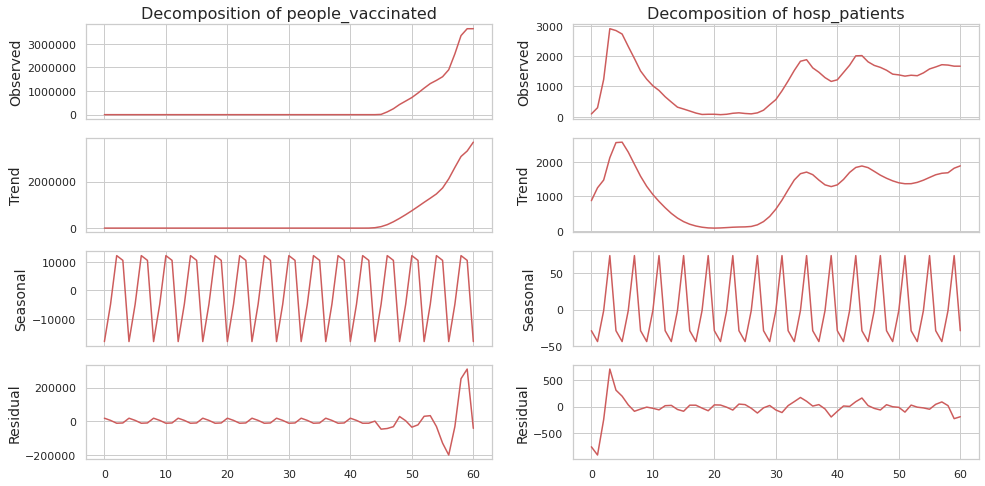

In [45]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['people_vaccinated', 'hosp_patients']):
    
    res = seasonal_decompose(df_n[column], freq=4, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='indianred')
    ax[0,i].set_ylabel('Observed', fontsize=14)
    ax[0,i].ticklabel_format(style='plain', axis='y')

    res.trend.plot(ax=ax[1,i], legend=False, color='indianred')
    ax[1,i].set_ylabel('Trend', fontsize=14)
    ax[1,i].ticklabel_format(style='plain', axis='y')

    res.seasonal.plot(ax=ax[2,i], legend=False, color='indianred')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    ax[2,i].ticklabel_format(style='plain', axis='y')
    
    res.resid.plot(ax=ax[3,i], legend=False, color='indianred')
    ax[3,i].set_ylabel('Residual', fontsize=14)
    ax[3,i].ticklabel_format(style='plain', axis='y')

plt.show()

Next what we want to do is calculate the _lag_ to compare the correlation with other variables. This will be done with the `shift()` method. We will be doing this to check for seasonality by plotting a greater number of periods (lags). Seasonality will repeat itself periodically.

In [46]:
weeks_in_month = 4

for column in core_columns:
    df_n[f'{column}_seasonal_shift_b_2m'] = df_n[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df_n[f'{column}_seasonal_shift_b_1m'] = df_n[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df_n[f'{column}_seasonal_shift_1m'] = df_n[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df_n[f'{column}_seasonal_shift_2m'] = df_n[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df_n[f'{column}_seasonal_shift_3m'] = df_n[f'{column}_seasonal'].shift(3 * weeks_in_month)

Now we can check how our data looks like.

In [47]:
df_n.head()

,date,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index,total_cases_diff,people_fully_vaccinated_diff,hosp_patients_diff,total_deaths_diff,total_tests_diff,stringency_index_diff,total_cases_trend,total_cases_seasonal,people_vaccinated_trend,people_vaccinated_seasonal,people_fully_vaccinated_trend,people_fully_vaccinated_seasonal,hosp_patients_trend,hosp_patients_seasonal,total_deaths_trend,total_deaths_seasonal,total_tests_trend,total_tests_seasonal,stringency_index_trend,stringency_index_seasonal,total_cases_seasonal_shift_b_2m,total_cases_seasonal_shift_b_1m,total_cases_seasonal_shift_1m,total_cases_seasonal_shift_2m,total_cases_seasonal_shift_3m,people_vaccinated_seasonal_shift_b_2m,people_vaccinated_seasonal_shift_b_1m,people_vaccinated_seasonal_shift_1m,people_vaccinated_seasonal_shift_2m,people_vaccinated_seasonal_shift_3m,people_fully_vaccinated_seasonal_shift_b_2m,people_fully_vaccinated_seasonal_shift_b_1m,people_fully_vaccinated_seasonal_shift_1m,people_fully_vaccinated_seasonal_shift_2m,people_fully_vaccinated_seasonal_shift_3m,hosp_patients_seasonal_shift_b_2m,hosp_patients_seasonal_shift_b_1m,hosp_patients_seasonal_shift_1m,hosp_patients_seasonal_shift_2m,hosp_patients_seasonal_shift_3m,total_deaths_seasonal_shift_b_2m,total_deaths_seasonal_shift_b_1m,total_deaths_seasonal_shift_1m,total_deaths_seasonal_shift_2m,total_deaths_seasonal_shift_3m,total_tests_seasonal_shift_b_2m,total_tests_seasonal_shift_b_1m,total_tests_seasonal_shift_1m,total_tests_seasonal_shift_2m,total_tests_seasonal_shift_3m,stringency_index_seasonal_shift_b_2m,stringency_index_seasonal_shift_b_1m,stringency_index_seasonal_shift_1m,stringency_index_seasonal_shift_2m,stringency_index_seasonal_shift_3m
0,2020-03-08,193.666667,0.0,0.0,92.666667,1.666667,0.000000,11.110000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-7699.116667,-369.083409,0.0,-17793.667375,0.0,-4775.862070,876.235119,-29.187786,-1147.230952,37.982584,-29367.078571,-19421.186488,42.914964,-0.907891,-369.083409,-369.083409,NaN,NaN,NaN,-17793.667375,-17793.667375,NaN,NaN,NaN,-4775.862070,-4775.862070,NaN,NaN,NaN,-29.187786,-29.187786,NaN,NaN,NaN,37.982584,37.982584,NaN,NaN,NaN,-19421.186488,-19421.186488,NaN,NaN,NaN,-0.907891,-0.907891,NaN,NaN,NaN
1,2020-03-15,659.285714,0.0,0.0,298.142857,8.428571,2440.000000,37.034286,465.619048,0.0,205.476190,6.761905,2440.000000,25.924286,-1858.880952,-652.622223,0.0,-4812.723811,0.0,2608.896523,1250.494048,-44.212947,-471.907738,20.448755,-365.625000,9300.968274,50.634464,-0.620532,-652.622223,-652.622223,NaN,NaN,NaN,-4812.723811,-4812.723811,NaN,NaN,NaN,2608.896523,2608.896523,NaN,NaN,NaN,-44.212947,-44.212947,NaN,NaN,NaN,20.448755,20.448755,NaN,NaN,NaN,9300.968274,9300.968274,NaN,NaN,NaN,-0.620532,-0.620532,NaN,NaN,NaN
2,2020-03-22,2644.571429,0.0,0.0,1233.571429,89.428571,29273.142857,61.110000,1519.666667,0.0,935.428571,74.238095,24393.142857,24.075714,4613.761905,172.996824,0.0,12130.207141,0.0,3475.584619,1476.851190,-1.324852,307.208333,-25.079221,31041.589286,14548.774226,55.437321,0.479515,172.996824,172.996824,NaN,NaN,NaN,12130.207141,12130.207141,NaN,NaN,NaN,3475.584619,3475.584619,NaN,NaN,NaN,-1.324852,-1.324852,NaN,NaN,NaN,-25.079221,-25.079221,NaN,NaN,NaN,14548.774226,14548.774226,NaN,NaN,NaN,0.479515,0.479515,NaN,NaN,NaN
3,2020-03-29,7663.714286,0.0,0.0,2906.428571,463.142857,52558.000000,78.700000,3033.857143,0.0,1672.857143,292.714286,-3548.285714,17.590000,9118.839286,848.708808,0.0,10476.184046,0.0,-1308.619072,2125.053571,74.725585,768.410714,-33.352118,55025.875000,-4428.556012,69.094286,1.048908,848.708808,848.708808,NaN,NaN,NaN,10476.184046,10476.184046,NaN,NaN,NaN,-1308.619072,-1308.619072,NaN,NaN,NaN,74.725585,74.725585,NaN,NaN,NaN,-33.352118,-33.352118,NaN,NaN,NaN,-4428.556012,-4428.556012,NaN,NaN,NaN,1.048908,1.048908,NaN,NaN,NaN
4,2020-04-05,14781.285714,0.0,0.0,2845.857143,1334.000000,79790.428571,78.700000,2098.428571,0.0,-60.571429,497.142857,3947.571

We have some `NaN` values from the __shifted__ columns which we will be looking into if they cause troubles.

Now that we have cleaned up and transformed the data, we can go into an __EDA__ (Exploratory Data Analysis).
***

## <center>6. Exploratory Data Analysis 📊</center>

Now, we are going to plot and extract knowledge from our data.

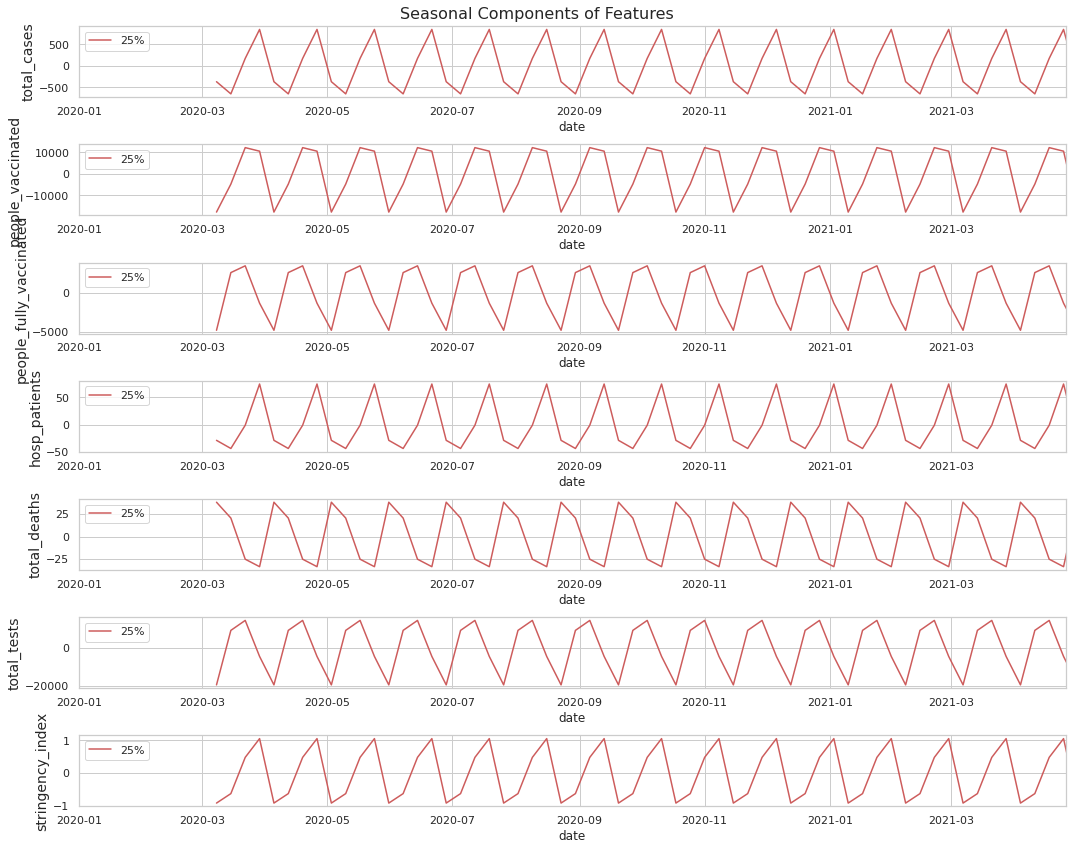

In [49]:
fig, ax = plt.subplots(nrows=len(core_columns), ncols=1, figsize=(15, 12))
fig.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df_n['date'], y=df_n[column + '_seasonal'], ax=ax[i], color='indianred', label='25%')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    ax[i].ticklabel_format(style='plain', axis='y')

fig.tight_layout()

As we can see, the data is mostly noise, meaning that there is no __seasonality__.

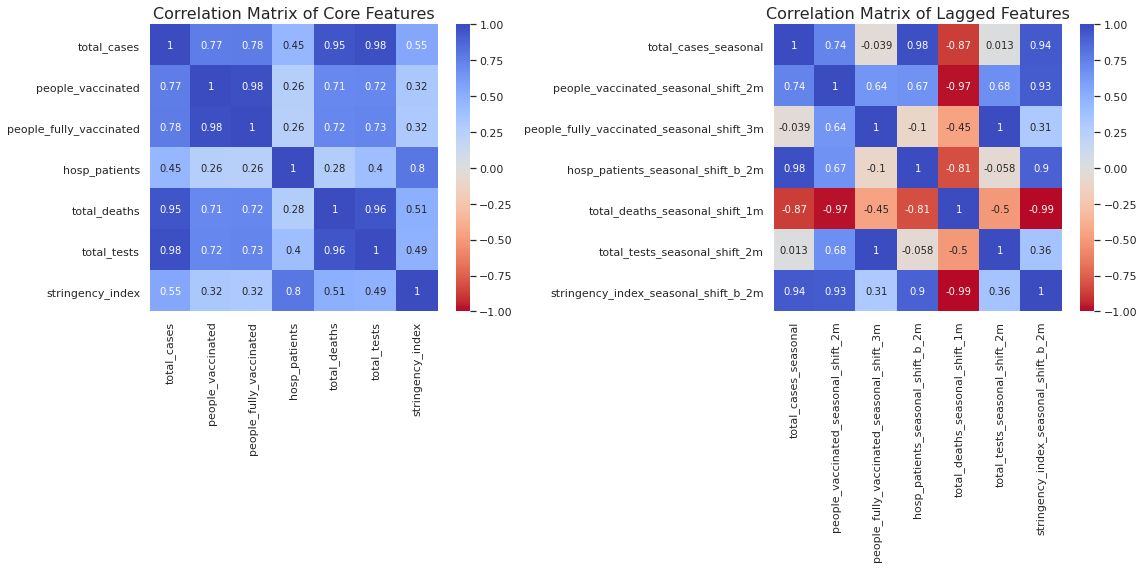

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corr_matrix = df_n[core_columns].corr()

sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

lagged_cols = [
    'total_cases_seasonal',
    'people_vaccinated_seasonal_shift_2m',
    'people_fully_vaccinated_seasonal_shift_3m',
    'hosp_patients_seasonal_shift_b_2m',
    'total_deaths_seasonal_shift_1m',
    'total_tests_seasonal_shift_2m',
    'stringency_index_seasonal_shift_b_2m'
]

corr_matrix = df_n[lagged_cols].corr()

sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)

fig.tight_layout()